# 6. Time travel

In a typical chatbot workflow, the user interacts with the bot one or more times to accomplish a task. [Memory](/oss/3-add-memory) and a [human-in-the-loop](/oss/4-human-in-the-loop) enable checkpoints in the graph state and control future responses.

What if you want a user to be able to start from a previous response and explore a different outcome? Or what if you want users to be able to rewind your chatbot's work to fix mistakes or try a different strategy, something that is common in applications like autonomous software engineers?

You can create these types of experiences using LangGraph's built-in **time travel** functionality.

This tutorial builds on [Customize state](/oss/5-customize-state).

## 1. Rewind your graph

Rewind your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.


In [28]:
import os
import getpass
from langchain.chat_models import init_chat_model

# Function to securely get OpenAI API key
def get_openai_api_key():
    """Securely prompt user for OpenAI API key"""
    # First try to get from environment variable
    api_key = os.environ.get("OPENAI_API_KEY")
    
    if not api_key:
        print("OpenAI API key not found in environment variables.")
        print("Please enter your OpenAI API key:")
        print("Note: Your input will be hidden for security.")
        api_key = getpass.getpass("OpenAI API Key: ")
        
        if api_key:
            # Set it for this session only
            os.environ["OPENAI_API_KEY"] = api_key
            print("API key set for this session.")
        else:
            raise ValueError("OpenAI API key is required to run this chatbot.")
    
    return api_key

# Get the API key securely
api_key = get_openai_api_key()

# Initialize the chat model
llm = init_chat_model("openai:gpt-4.1")

In [29]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

## 2. Visualize the graph

Visualizing the graph, you get the same layout as before – just with the added tool!

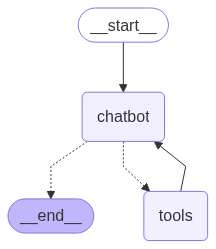

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 3. Add steps

Add steps to your graph. Every step will be checkpointed in its state history:


In [31]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph.js. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph.js. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_eNarX57yPSOIIASZFGDp8wYv)
 Call ID: call_eNarX57yPSOIIASZFGDp8wYv
  Args:
    query: LangGraph.js overview, documentation, and tutorials
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph.js overview, documentation, and tutorials", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcommunity.microsoft.com/blog/educatordeveloperblog/an-absolute-beginners-guide-to-langgraph-js/4212496", "title": "An Absolute Beginner's Guide to LangGraph.js", "content": "By the end of this guide, you will:\n\n## Overview of LangGraph.js\n\nLangGraph.js is a JavaScript library designed to simplify the creati

In [32]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an network type multi-agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an network type multi-agent with it!
================================== Ai Message ==================================

That’s a great idea! LangGraph.js is particularly well-suited for building networked, multi-agent systems because of its graph-based approach. Here’s why it’s a strong fit for your project:

- Each “agent” can be represented as a node with its own logic or personality.
- Edges control how and when agents interact, forming a network.
- The shared state allows agents to pass information, collaborate, and build context together.

If you’re inspired to start, here are some tips and resources:

1. Example Use Case: Multi-Agent Systems  
The official LangGraph.js tutorials include a section on multi-agent architectures. You can find step-by-step guides and code snippets for setting up agent networks and orchestrating their interactions:  
https://langchain-ai

## 4. Replay the full state history

Now that you have added steps to the chatbot, you can `replay` the full state history to see everything that occurred.


In [33]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


Checkpoints are saved for every step of the graph. This **spans invocations** so you can rewind across a full thread's history.

## Resume from a checkpoint

Resume from the `to_replay` state, which is after the `chatbot` node in the second graph invocation. Resuming from this point will call the **action** node next.


In [34]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07eb3d-05d2-61d4-8001-f159efed9dec'}}


## 5. Load a state from a moment-in-time

The checkpoint's `to_replay.config` contains a `checkpoint_id` timestamp. Providing this `checkpoint_id` value tells LangGraph's checkpointer to **load** the state from that moment in time.


In [35]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_eNarX57yPSOIIASZFGDp8wYv)
 Call ID: call_eNarX57yPSOIIASZFGDp8wYv
  Args:
    query: LangGraph.js overview, documentation, and tutorials
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph.js overview, documentation, and tutorials", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcommunity.microsoft.com/blog/educatordeveloperblog/an-absolute-beginners-guide-to-langgraph-js/4212496", "title": "An Absolute Beginner's Guide to LangGraph.js", "content": "By the end of this guide, you will:\n\n## Overview of LangGraph.js\n\nLangGraph.js is a JavaScript library designed to simplify the creation and manipulation of complex LLM-based workflows. It particularly shines when creating agentic workflows—systems that use an LLM to decide the cours

The graph resumed execution from the `tools` node. You can tell this is the case since the first value printed above is the response from our search engine tool.
